In [1]:
%load_ext autotime

In [2]:
import ctypes
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.ticker import FuncFormatter, AutoMinorLocator

time: 2.65 s


In [22]:
file = "example.bin" # replace with actual file

time: 8.01 ms


In [20]:
class SensorDataBits(ctypes.LittleEndianStructure):
    """Helper class to read values."""
    _fields_ = [
        ('value2', ctypes.c_uint, 14),
        ('value1', ctypes.c_uint, 14),
        ('sensor_num', ctypes.c_uint, 4)
    ]
    
class SensorData(ctypes.Union):
    """Helper class to read values."""
    _fields_ = [
        ('bit_field', SensorDataBits),
        ('byte_data', ctypes.c_uint32)
    ]

def read_data(sensor, start, stop, filename, step_size=None):
    """Reads the data of a sensor.
    
    The step size will be calculated automatically if not given.
    If it is 1 every data point is considered (may take ages).
    
    If no start and stop is given (both 0) the whole file is considered.
    """
    print("Filename:", filename)
    with open(filename, 'rb') as f:
        if sensor < 1 or sensor > 8:
            print('Sensor must be between 1 and 8')
            return
        sensor -= 1 # actully sensors are [0..7]
        # get file size
        f.seek(0, os.SEEK_END)
        size = f.tell() # size in byte
        total_value_count = (size/4) * 2

        # if the files contains not enough data it is pointless
        if total_value_count < 16:
            print('The measurement file is garbage.')
            return

        # find sensor in data and count active sensors
        f.seek(0)
        data = f.read(32) # read first 8 32 bit values
        sensors = 8 * [0]
        for i in range(8):
            index = i * 4
            value = int.from_bytes(data[index:index+4], "little")
            sensors[i] = value >> 28
        sensor_index = -1
        first_sensor = -1
        active_sensor_count = 0
        for i, value in enumerate(sensors):
            if i == 0:
                first_sensor = value
            elif value == first_sensor:
                active_sensor_count = i
                break
            if value == sensor:
                sensor_index = i
        if sensor_index == -1:
            print('sensor not within data')
            return
        if active_sensor_count == 0: # all 8 sensors active
            active_sensor_count = 8

        # correct value count according to sensors count
        total_value_count /= active_sensor_count
        
        # seek distance
        seek_distance = 4 * active_sensor_count
        
        # clamp start and stop
        if start == 0 and stop == 0:
            stop = total_value_count - 1
        else:
            if start < 0:
                start = 0
            elif start >= total_value_count - 1:
                start = total_value_count - 2
            if stop < 1:
                stop = 1
            elif stop >= total_value_count:
                stop = total_value_count - 1
            if start >= stop:
                stop = start + 1
        if not step_size:
            step_size = 1
            if stop - start > 2000:
                step_size = int((stop-start) / 2000)
        x_array = np.arange(start, stop, step_size)
        y_array = np.empty(len(x_array), dtype=np.uint16)
        data_pos = start
        index = 0
        byte_data = SensorData()
        while index < len(x_array):
            f.seek((data_pos >> 1)*seek_distance + sensor_index * 4) # data_pos / 2 because 2 values are within 32 bit value
            data = f.read(4)
            byte_data.byte_data = int.from_bytes(data, "little")
            value1, value2 = byte_data.bit_field.value1, byte_data.bit_field.value2
            if data_pos % 2 == 0:
                y_array[index] = value1
                index += 1
                if index >= len(x_array):
                    break
                if step_size == 1:
                    y_array[index] = value2
                    index += 1
                    data_pos += 2
                else:
                    data_pos += step_size
            else:
                y_array[index] = value2
                index += 1
                data_pos += step_size
        return {'start': start, 'stop': stop-1, 'x': x_array, 'y': y_array}
    
def running_mean(x, N):
    """Calculates the running mean and returns an array."""
    return pd.Series(x).rolling(window=N).mean().iloc[N-1:].values

def detect_peaks(data, num=250, trigger=25):
    """Uses the dynamic trigger to detect impulses.
    
    It returns the ranges within the data where the impulses were detected.
    """
    mean_values = running_mean(data, num)
    length = len(mean_values)
    data_dir = 0
    low_val = 0
    high_val = 0
    impuls_ranges = []
    i = 0
    while i < length:
        mean_value = int(mean_values[i])
        if data_dir == 0:
            data_dir = -1
            low_val = mean_value
        elif data_dir == -1:
            if mean_value < low_val:
                low_val = mean_value
            elif mean_value > low_val + trigger:
                impuls_ranges.append([i, 0])
                data_dir = 1
                high_val = mean_value
        elif data_dir == 1:
            if mean_value > high_val:
                high_val = mean_value
            elif mean_value < high_val - trigger:
                impuls_ranges[-1][1] = i
                data_dir = -1
                low_val = mean_value
        i += 1
    if len(impuls_ranges) > 0 and impuls_ranges[-1][1] == 0:
        impuls_ranges[-1][1] = i
    print('impuls count:', len(impuls_ranges))
    return {'ranges': impuls_ranges, 'mean_num': num}

def calculate_ylabel(tick_val, tick_pos):
    """Just to show correct units."""
    return '{:.2f}'.format(((tick_val / 0b11111111111111) * 2 - 1) * 1000)

def calculate_xlabel(tick_val, tick_pos):
    """Just to show correct units."""
    return '{:,}'.format(int(tick_val * 100))

def plot_data(values, ranges=None):
    """Plots the values to a graph.
    
    The ranges parameter is to print detected impulse ranges by "detect_peaks".
    """
    #with plt.xkcd(): # comic style
        fig, ax = plt.subplots()
        fig.dpi = 80
        fig.facecolor = 'w'
        fig.edgecolor = 'k'
        fig.set_size_inches(15, 6)
        plt.xlabel('t in ns')
        plt.ylabel('U in mV')
        plt.xlim(values['start'], values['stop'])
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))
        ax.yaxis.set_major_formatter(FuncFormatter(calculate_ylabel))
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))
        ax.xaxis.set_major_formatter(FuncFormatter(calculate_xlabel))
        if ranges != None:
            for _range in ranges['ranges']:
                plt.axvspan(_range[0]+values['start']+ranges['mean_num'], _range[1]+values['start'], color='green', alpha=0.5)
        ax.plot(values['x'], values['y'])
        
def print_patterns(sensor, filename):
    """Function to be used when testing the ADC.
    
    It prints a value of a measurement as soon as a value change is detected within the data.
    """
    data = read_data(sensor, 0, 0, filename, 1)
    if data:
        last_value = -1
        for value in data['y']:
            if value != last_value:
                print('Pattern: {}'.format(bin(value)))
                last_value = value

time: 20.5 ms


impuls count: 37 [[856, 1212], [1604, 1930], [3345, 3673], [8446, 8772], [9853, 10353], [11259, 11566], [13720, 14042], [14910, 15230], [16700, 16998], [18394, 18731], [19002, 19345], [20159, 20451], [20990, 21410], [21979, 22443], [22758, 23017], [23249, 23561], [25329, 25597], [25817, 26136], [26806, 27123], [27318, 27634], [28665, 28957], [30573, 30899], [31241, 31522], [31596, 31718], [31814, 31841], [32000, 32341], [32591, 32834], [35271, 35595], [37314, 37637], [41900, 42224], [42613, 42905], [43140, 43382], [44249, 44557], [46700, 46961], [47208, 47522], [48221, 48645], [49293, 49536]]


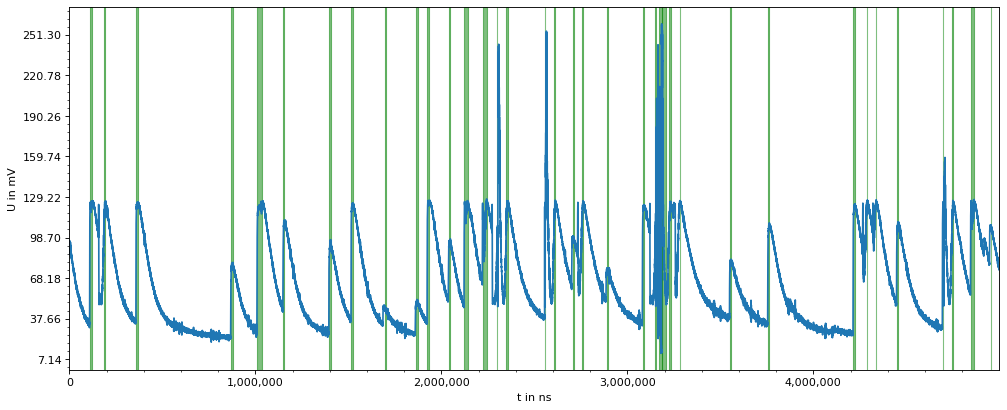

time: 500 ms


In [23]:
data = read_data(1, 0, 50000, file, 1)
impuls_ranges = detect_peaks(data['y'])
if data:
    plot_data(data, impuls_ranges)